In [1]:
import warnings
warnings.filterwarnings('ignore')
import quandl
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing, cross_validation, svm, metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
from matplotlib import style
import time, datetime

style.use('ggplot')

/home/ayrus/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#only one time needed for saving data from quandl.com
#df = quandl.get('WIKI/GOOGL')
#df.to_pickle('google_stocks.pickle')

In [4]:
df = pd.read_csv('data/train.csv')

In [10]:
df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,...,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,...,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,...,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06


In [5]:
df = df[['Open','Close','Adj. Open','Adj. Close','Adj. Volume','Adj. Low','Adj. High']]
df.head()

,Open,Close,Adj. Open,Adj. Close,Adj. Volume,Adj. Low,Adj. High
Date,,,,,,,
2004-08-19,100.01,100.335,50.159839,50.322842,44659000.0,48.128568,52.191109
2004-08-20,101.01,108.310,50.661387,54.322689,22834300.0,50.405597,54.708881
2004-08-23,110.76,109.400,55.551482,54.869377,18256100.0,54.693835,56.915693
2004-08-24,111.24,104.870,55.792225,52.597363,15247300.0,51.945350,55.972783
2004-08-25,104.76,106.000,52.542193,53.164113,9188600.0,52.100830,54.167209


In [6]:
df['HL_PCT'] = (df['Adj. High']-df['Adj. Close'])/df['Adj. Close']*100
df['PCT_change'] = (df['Adj. Close']-df['Adj. Open'])/df['Adj. Open']*100
df = df[['Adj. Close','Adj. Volume','PCT_change','HL_PCT']]

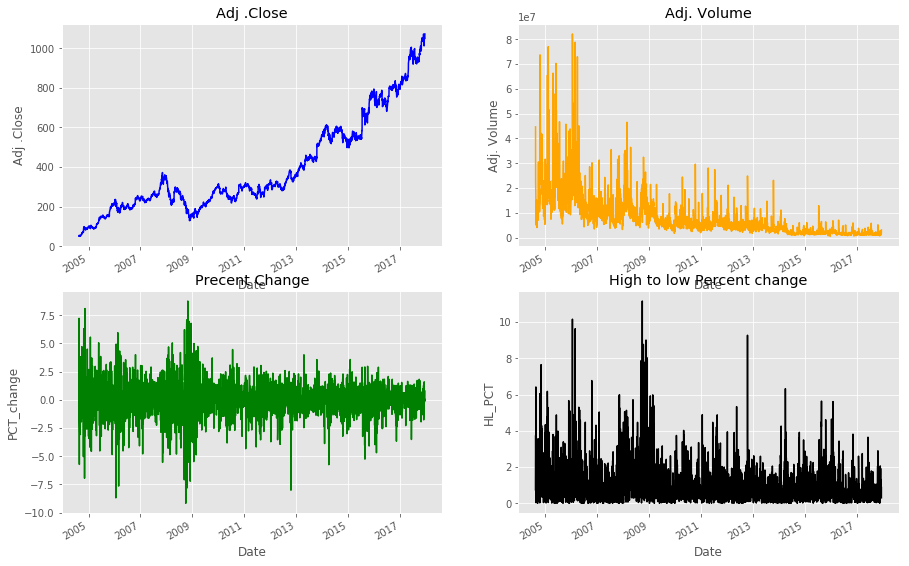

In [7]:

fig = plt.figure()
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2),(0,0))
ax1.set_title('Adj .Close')
ax1.set_ylabel('Adj .Close')

ax2 = plt.subplot2grid((2,2),(0,1))
ax2.set_title('Adj. Volume')
ax2.set_ylabel('Adj. Volume')

ax3 = plt.subplot2grid((2,2),(1,0))
ax3.set_title('Precent Change')
ax3.set_ylabel('PCT_change')

ax4 = plt.subplot2grid((2,2),(1,1))
ax4.set_title('High to low Percent change')
ax4.set_ylabel('HL_PCT')

df['Adj. Close'].plot(ax = ax1,color='blue')
df['Adj. Volume'].plot(ax = ax2,color='orange')
df['PCT_change'].plot(ax = ax3,color='green')
df['HL_PCT'].plot(ax = ax4,color='black')
plt.show()

In [8]:
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(.02*len(df))
df['label'] = df[forecast_col].shift(-forecast_out)

In [15]:
X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# X.reshape(-1,1)
df.dropna(inplace=True)
y = np.array(df['label']).astype('int')
print(len(X),len(y))
df.tail()
# print(df.iloc[:1])

3222 3289


,Adj. Close,Adj. Volume,PCT_change,HL_PCT,label
Date,,,,,
2017-09-05,941.48,1455058.0,-0.568194,1.052109,1051.97
2017-09-06,942.02,1375952.0,-0.196002,0.263264,1048.77
2017-09-07,949.89,1103286.0,0.597299,0.063849,1051.39
2017-09-08,941.41,996449.0,-0.872907,0.986818,1057.47
2017-09-11,943.29,1317796.0,-0.412796,0.995452,1072.00


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

In [16]:
clf = LinearRegression()
# clf = svm.SVR()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)


0.9595097814957243

In [25]:
# clf = LinearRegression()
# clf = svm.SVR()
m = 0
index = 0
for i in range(1,100):
    clf = KNeighborsRegressor(n_neighbors=i,weights='distance')
    # clf = KNeighborsRegressor(n_neighbors=2,weights='uniform')
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    if(score>m):
        m = score
        index = i
print('score:',m,'\nn_neighbors:',index)
y_pred  = clf.predict(X_test)
print('mean_absolute_error',metrics.mean_absolute_error(y_test, y_pred))
print('mean_squared_error',metrics.mean_squared_error(y_test, y_pred))
print('mean_squared_error',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

score: 0.9605289299827796 
n_neighbors: 8
mean_absolute_error 40.5744209149123
mean_squared_error 2953.6771465808592
mean_squared_error 54.34774279195834


In [26]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

In [30]:
last_date = df.iloc[-1].name
print(df.iloc[-1])
print(df.tail(),last_date)
last_unix = time.mktime(last_date.timetuple())
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

Adj. Close            NaN
Adj. Volume           NaN
PCT_change            NaN
HL_PCT                NaN
label                 NaN
Forecast       965.794341
Name: 2018-06-06 00:00:00, dtype: float64
            Adj. Close  Adj. Volume  PCT_change  HL_PCT  label    Forecast
Date                                                                      
2018-06-02         NaN          NaN         NaN     NaN    NaN  976.995818
2018-06-03         NaN          NaN         NaN     NaN    NaN  954.964408
2018-06-04         NaN          NaN         NaN     NaN    NaN  976.168359
2018-06-05         NaN          NaN         NaN     NaN    NaN  975.667769
2018-06-06         NaN          NaN         NaN     NaN    NaN  965.794341 2018-06-06 00:00:00


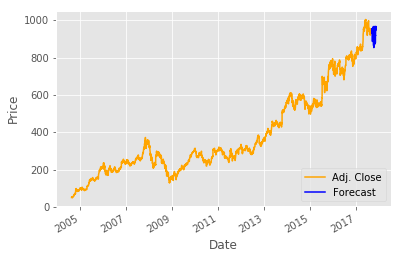

In [14]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
# fig = plt.figure(figsize=(10,8))
df['Adj. Close'].plot(color='orange')
df['Forecast'].plot(color='blue')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [21]:
p = pd.read_html('https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20171201&end=20180126')

[            Date     Open     High       Low    Close       Volume  \
 0   Jan 26, 2018  11256.0  11656.7  10470.30  11171.4   9746200000   
 1   Jan 25, 2018  11421.7  11785.7  11057.40  11259.4   8873170000   
 2   Jan 24, 2018  10903.4  11501.4  10639.80  11359.4   9940990000   
 3   Jan 23, 2018  10944.5  11377.6  10129.70  10868.4   9660610000   
 4   Jan 22, 2018  11633.1  11966.4  10240.20  10931.4  10537400000   
 5   Jan 21, 2018  12889.2  12895.9  11288.20  11600.1   9935180000   
 6   Jan 20, 2018  11656.2  13103.0  11656.20  12899.2  11801700000   
 7   Jan 19, 2018  11429.8  11992.8  11172.10  11607.4  10740400000   
 8   Jan 18, 2018  11198.8  12107.3  10942.50  11474.9  15020400000   
 9   Jan 17, 2018  11431.1  11678.0   9402.29  11188.6  18830600000   
 10  Jan 16, 2018  13836.1  13843.1  10194.90  11490.5  18853800000   
 11  Jan 15, 2018  13767.3  14445.5  13641.70  13819.8  12750800000   
 12  Jan 14, 2018  14370.8  14511.8  13268.00  13772.0  11084100000   
 13  J